# Count-based_Representation

indeed.com 에서 Data Scientist 키워드로 Job descrition을 찾아 스크래핑한 데이터를 이용해 과제를 진행해 보겠습니다.

[Data_Scienties.csv](https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/indeed/Data_Scientist.csv) 파일에는 1300여개의 Data Scientist job description 정보가 담겨 있습니다.

## 1. 데이터 전처리 (Text preprocessing)

In [1]:
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 0) 텍스트 분석에 앞서 데이터 전처리를 진행합니다.

- 파일을 불러온 후 title, company, description 에 해당하는 Column만 남겨주세요.
- 중복값을 제거하세요.

In [2]:
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/indeed/Data_Scientist.csv')

In [3]:
df = df[['title', 'company', 'description']].drop_duplicates()

In [4]:
df.shape

(757, 3)

In [5]:
df

,title,company,description
0,Data Scientist (Structured Products),EquiTrust Life Insurance Company,Job Details\nDescription\nEssential Duties and...
2,"Specialist, Data Science",Nationwide,As a team member in the Finance and Internal A...
4,Sr. Data Scientist (Remote),American Credit Acceptance,Overview:\nAmerican Credit Acceptance seeks a ...
5,Data Scientist Associate Sr (DADS06) BTB - LEG...,"JPMorgan Chase Bank, N.A.",J.P. Morgan's Corporate & Investment Bank (CIB...
6,Data Scientist,VyStar Credit Union,"At VyStar, we offer competitive pay, an excell..."
...,...,...,...
1288,Senior Data Analyst,Intuit,Our Expert Delivery & Business Intelligence te...
1294,"Senior / Data Scientist, Advertising Business",Spotify,"Music for everyone, no credit card needed. It’..."
1295,Senior Data & Applied Scientist,Microsoft,Senior Data & Applied Scientist\nDo you have a...
1297,Senior Data Scientist,eBay Inc.,eBay is a global commerce leader that allows y...


### 1) 토큰을 정제합니다.

- 문자를 소문자로 통일
- 분석에 관련 없는 정보 제거
- 이번 과제는 `spacy` 로부터 `"en_core_web_sm"` 을 로드하여 진행해주세요.

- **문항 1) 대문자를 소문자로 변경하는 함수를 입력하세요.**
- **문항 2) 정규 표현식을 사용하여 re 라이브러리에서 알파벳 소문자, 숫자만 받을 수 있는 코드를 작성하세요.**

In [6]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

In [7]:
def prepro(text):

  regex = r"[^a-zA-Z0-9\n\n\n ]"
  text = re.sub(regex, "", text)
  text = text.lower().split()
  return text



df['tokens'] = df['description'].apply(prepro)
df['tokens'].tail(1)

1299    [tldr, spring, is, accelerating, the, discover...
Name: tokens, dtype: object

### 2) 정제한 토큰을 시각화 합니다.

- Top 10 토큰을 프린트 합니다.
- 토큰의 수, 빈도 순위, 존재 문서 수, 비율 등 정보를 계산합니다.
- 토큰 순위에 따른 퍼센트 누적 분포 그래프를 시각화합니다.

- **문항 3) 추천 토큰 순위 10개 단어를 입력하세요.**

In [8]:
from collections import Counter

word_counts = Counter()
df['tokens'].apply(lambda x: word_counts.update(x))
word_counts.most_common(10)

[('and', 21863),
 ('to', 12694),
 ('the', 10538),
 ('of', 8839),
 ('data', 7425),
 ('in', 6769),
 ('a', 6436),
 ('with', 5727),
 ('for', 4132),
 ('or', 3812)]

In [9]:
def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [10]:
wc = word_count(df['tokens'])
wc_top10 = wc[wc['rank'] <= 10]
wc_top10

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
118,and,755,21863,1.0,0.056454,0.056454,0.997358
60,to,754,12694,2.0,0.032778,0.089231,0.996037
147,the,745,10538,3.0,0.027211,0.116442,0.984148
216,of,745,8839,4.0,0.022824,0.139266,0.984148
225,data,740,7425,5.0,0.019172,0.158438,0.977543
100,in,748,6769,6.0,0.017479,0.175917,0.988111
130,a,739,6436,7.0,0.016619,0.192536,0.976222
86,with,742,5727,8.0,0.014788,0.207323,0.980185
561,for,727,4132,9.0,0.010669,0.217993,0.960370
181,or,708,3812,10.0,0.009843,0.227836,0.935271


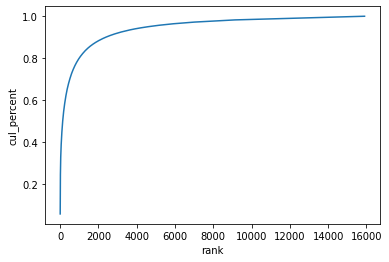

In [11]:
import seaborn as sns

sns.lineplot(x='rank', y='cul_percent', data=wc);

### 4) 확장된 불용어 사전을 사용해 토큰을 정제합니다.

- **문항 4) 기본 불용어 사전에 두 단어(`"data", "work"`)를 추가하는 코드를 사용해주세요.**
- **문항 5) 불용어를 제거하고 난 뒤 토큰 순위 10개의 단어를 입력하세요.**

In [12]:
def prepro2(text):

  regex = r"[^a-zA-Z0-9\n\n\n ]"
  text = re.sub(regex, "", text)
  text = text.lower()
  text = text.replace('\n', ' ')
  text = text.replace('  ', ' ')
  return text

df['text'] = df['description'].apply(prepro2)

In [13]:
STOP_WORDS = nlp.Defaults.stop_words.union(['data', 'work', '\n', '\n\n']) #  '\n', '\n\n'

tokens = []

for doc in tokenizer.pipe(df['text']):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text not in STOP_WORDS:
            doc_tokens.append(token.text)
   
    tokens.append(doc_tokens)
    
df['tokens2'] = tokens

In [14]:
wc = word_count(df['tokens2'])
wc.head(10)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
128,experience,705,3450,1.0,0.014376,0.014376,0.931308
391,business,536,2064,2.0,0.008601,0.022977,0.708058
193,science,611,1648,3.0,0.006867,0.029845,0.807133
28,team,588,1625,4.0,0.006771,0.036616,0.776750
211,learning,526,1596,5.0,0.006651,0.043267,0.694848
19,analysis,516,1349,6.0,0.005621,0.048888,0.681638
137,skills,547,1251,7.0,0.005213,0.054101,0.722589
526,machine,470,1152,8.0,0.004800,0.058901,0.620872
520,analytics,428,1136,9.0,0.004734,0.063635,0.565390
136,models,459,1034,10.0,0.004309,0.067944,0.606341


### 5) Lemmatization 사용 효과를 분석해 봅니다.

- **문항 6) Lemmatization을 진행한 뒤 상위 10개 단어를 입력하세요.**

In [15]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)

    for token in doc: 
        if ((token.text not in STOP_WORDS) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [16]:
df['lemmas'] = df['text'].apply(get_lemmas)
df['lemmas']

0       [job, detail, description, essential, duty, re...
2       [team, member, finance, internal, audit, depar...
4       [overview, american, credit, acceptance, seek,...
5       [jp, morgans, corporate, investment, bank, cib...
6       [vystar, offer, competitive, pay, excellent, b...
                              ...                        
1288    [expert, delivery, business, intelligence, tea...
1294    [music, credit, card, need, promise, platform,...
1295    [senior, apply, scientist, passion, machine, l...
1297    [ebay, global, commerce, leader, allow, shape,...
1299    [tldr, spring, accelerate, discovery, therapy,...
Name: lemmas, Length: 757, dtype: object

In [17]:
wc = word_count(df['lemmas'])
wc.head(10)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
127,experience,707,3623,1.0,0.015104,0.015104,0.933950
29,team,636,2299,2.0,0.009584,0.024688,0.840159
358,business,544,2156,3.0,0.008988,0.033676,0.718626
185,science,620,1719,4.0,0.007166,0.040843,0.819022
21,analysis,544,1590,5.0,0.006629,0.047471,0.718626
140,model,534,1520,6.0,0.006337,0.053808,0.705416
406,analytic,453,1403,7.0,0.005849,0.059657,0.598415
26,skill,553,1303,8.0,0.005432,0.065089,0.730515
5,product,443,1287,9.0,0.005365,0.070454,0.585205
76,include,510,1175,10.0,0.004898,0.075353,0.673712


## 2. 유사한 문서 찾기

### 1) `TfidfVectorizer`를 이용해 각 문서들을 벡터화 한 후 KNN 모델을 만들고, <br/> 내가 원하는 `job description`을 질의해 가장 가까운 검색 결과들을 가져오고 분석합니다.

- **문항 9) 88번 index의 `job description`와 5개의 가장 유사한 `job description`이 있는 index를 입력하세요.**
    - 답은 88번 인덱스를 포함합니다.
    - `max_features = 3000` 으로 설정합니다.
    - [88, 90, 91, 93, 94] 형태로 답을 입력해주세요

In [18]:
df.head(3)

,title,company,description,tokens,text,tokens2,lemmas
0,Data Scientist (Structured Products),EquiTrust Life Insurance Company,Job Details\nDescription\nEssential Duties and...,"[job, details, description, essential, duties,...",job details description essential duties and r...,"[job, details, description, essential, duties,...","[job, detail, description, essential, duty, re..."
2,"Specialist, Data Science",Nationwide,As a team member in the Finance and Internal A...,"[as, a, team, member, in, the, finance, and, i...",as a team member in the finance and internal a...,"[team, member, finance, internal, audit, depar...","[team, member, finance, internal, audit, depar..."
4,Sr. Data Scientist (Remote),American Credit Acceptance,Overview:\nAmerican Credit Acceptance seeks a ...,"[overview, american, credit, acceptance, seeks...",overview american credit acceptance seeks a hi...,"[overview, american, credit, acceptance, seeks...","[overview, american, credit, acceptance, seek,..."


In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

tfidf = TfidfVectorizer(stop_words='english', max_features=3000)

dtm_tfidf = tfidf.fit_transform(df['text'])

dtm_tfidf = pd.DataFrame(dtm_tfidf.todense(), columns=tfidf.get_feature_names_out())


In [21]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm_tfidf)
nn.kneighbors([dtm_tfidf.iloc[88]])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


(array([[0.        , 1.12318245, 1.19016226, 1.19203945, 1.19266534]]),
 array([[ 88,  40, 680, 193, 121]]))

## 3. TF-IDF 이용한 텍스트 분류 진행하기

TF-IDF를 이용해 문장 혹은 문서를 벡터화한 경우, 이 벡터값을 이용해 문서 분류 태스크를 진행할 수 있습니다. 

현재 다루고 있는 데이터셋에는 label이 존재하지 않으므로, title 컬럼에 "Senior"가 있는지 없는지 여부를 통해 Senior 직무 여부를 분류하는 작업을 진행해보겠습니다.

### 1) title 컬럼에 "Senior" 문자열이 있으면 1, 없으면 0인 "Senior"라는 새로운 컬럼을 생성해주세요.

문항 7) 새롭게 만든 Senior 컬럼에서 값이 1인 (Senior O) 데이터의 개수는?

In [22]:
# df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/indeed/Data_Scientist.csv')
# df = df[['title', 'company', 'description']].drop_duplicates()

In [23]:
df['Senior'] = df['title'].apply(lambda x: 1 if "Senior" in x else 0)
df[df['Senior']==1].shape

(95, 8)

문항 8) sklearn의 `train_test_split`을 통해 train 데이터와 valid 데이터로 나눈 후, `sklearn`의 `DecisionTreeClassifier`를 이용해 분류를 진행해주세요. 

단, x값은 위에서 학습한 dtm_tfidf를 그대로 이용해주세요. train_test_split과 DecisionTreeClassifier의 random_state을 42로 고정하고, test_size는 0.1로 설정해주세요.

학습을 완료한 후, test 데이터에 대한 예측을 진행하고 label 1에 대한 precision과 recall 값을 적어주세요

In [24]:
dtm_tfidf

,10,100,1000,11,12,13,14,15,18,20,...,year,years,yes,york,youll,youre,youve,yrs,zillow,zulily
0,0.056144,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.023288,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.018726,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.017487,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.041329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.029402,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030225,...,0.0,0.047403,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
753,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.052952,0.069941,0.000000,0.0,0.0,0.0,0.0
754,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058037,...,0.0,0.018204,0.000000,0.000000,0.034788,0.000000,0.0,0.0,0.0,0.0
755,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053426,...,0.0,0.067030,0.000000,0.000000,0.032024,0.044958,0.0,0.0,0.0,0.0


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(dtm_tfidf, df['Senior'], test_size = 0.1, random_state = 42, stratify = df['Senior'])

In [27]:
clr = DecisionTreeClassifier(random_state=42)
clr.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [28]:
y_pred = clr.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        66
           1       0.10      0.10      0.10        10

    accuracy                           0.76        76
   macro avg       0.48      0.48      0.48        76
weighted avg       0.76      0.76      0.76        76

